# Doing things with text 5

## TF-IDF on multiple texts

### Import packages

In [1]:
import os
from bs4 import BeautifulSoup
import unicodedata
import re
from nltk.tokenize import word_tokenize  # needs to be installed first via nltk.download()
from nltk.corpus import stopwords  # needs to be installed first via nltk.download()
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Define in- and out-directories

Indir is a folder on your computer with multiple text files. Outdir is a folder (to be made) to store cleaned versions of the files

In [2]:
indir = r'/Users/huijn001/surfdrive/data_lokaal/medisch_contact_txt_clean/'
outdir = r'/Users/huijn001/desktop/test/'
os.makedirs(os.path.dirname(outdir), exist_ok=True) # makes outdir if it doesn't exist already

#### User defined stopwords (for wordcloud and Counter)

In [ ]:
stopword_list = ['chorus', 'verse', 'outro', 'that', 'with', 'said', 'this', 'when', 'them', 'were', 'from', 'will', 'there', 'they', 'then', 'their', 'your', 'would', 'only', 'even', 'know', 'could', 'have', 'where', 'come', 'been', 'made', 'well', 'would', 'their', 'could', 'there']

## Preprocessing

In [ ]:
def remove_html(text):
    """ Use the library BeautifulSoup (bs4) to remove html tags """
    soup = BeautifulSoup(text, "lxml")
    clean_text = soup.get_text()
    return clean_text

def remove_short_words(words, n=5):
    new_words = []
    for word in words:
        if len(word) >= n:
            new_words.append(word)
    return new_words

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all integer occurrences in list of tokenized words
    """
    new_words = []
    for word in words:
        if not word.isdigit():
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_stop_words_languages(words, languages=['dutch', 'french']):
    """ Remove stop words from specified languages """
    all_stop_words = []
    for language in languages:
        all_stop_words.extend(stopwords.words(language))
    stop_words = list(set(all_stop_words))
    return remove_stop_words(words, stop_words)

def remove_stop_words(words, stop_words):
    """ Given a list of words and stop words, remove stop words """
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

In [ ]:
def all_operations(words):
    words = remove_short_words(words)
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = to_lowercase(words)
    words = remove_stop_words_languages(words)
    return words

#### Call functions

Stores al text files from indir as strings in a list 

In [3]:
all_docs = []

# list all files in a given directory
files = os.listdir(indir)
files_clean = []

for infile in sorted(files):
    # avoid opening files such as .DS_Store
    if infile.startswith('.'):
        continue
    files_clean.append(infile)
    # open the file and do something with it, close when done
    with open(indir+infile, "r") as f:
        # try / except clause to catch encoding errors
        try:
            text = f.read()
        except Exception:
            print(Exception)
    # remove html
#    clean_text = remove_html(text)
    # tokenize to words (needed for subsequent operations)
#    words = word_tokenize(clean_text)
#    words = all_operations(words)
#    words_as_string = " ".join(words)
#    all_docs.append(words_as_string)
    all_docs.append(text)

In [4]:
print(files_clean)

['1945.txt', '1946.txt', '1947.txt', '1948.txt', '1949.txt', '1950.txt', '1951.txt', '1952.txt', '1953.txt', '1954.txt', '1955.txt', '1956.txt', '1957.txt', '1958.txt', '1959.txt', '1960.txt', '1961.txt', '1962.txt', '1963.txt', '1964.txt', '1965.txt', '1966.txt', '1967.txt', '1968.txt', '1969.txt', '1970.txt', '1971.txt', '1972.txt', '1973.txt', '1974.txt', '1975.txt', '1976.txt', '1977.txt', '1978.txt', '1979.txt', '1980.txt', '1981.txt', '1982.txt', '1983.txt', '1984.txt', '1985.txt', '1986.txt', '1987.txt', '1988.txt', '1989.txt', '1990.txt', '1991.txt', '1992.txt', '1993.txt', '1994.txt', '1995.txt', '1996.txt', '1997.txt', '1998.txt', '1999.txt']


In [8]:
print(all_docs[2])

jaargang april medisch contact officieel maatschappij bevordering commissie redactie heringa hoofdredacteur wibaut sturkop redactie administratie keizersgracht amsterdam inhoud hoofdhestuur bescherming praktijken vaststellen vergoeding gemobiliseerde indie gestelde arisen oudedagsverzorging communique nederlandsche volksgexpndheid rubeola oorzaak aangeboren afwijkingen hoofdbestoor bescherming vaststellen vergoedingen gemobiliseerde indifi gestelde artsen regeling specialisten welke onverklaarbare wijze aanvulling beschrijvingsbrief maart gehouden buitengewone algemeene vergadering uitgevallen volgt hieronder algemeene vergadering besloten gedeelte regeling bespreking constitueerende vergadering april langs schriftelijken specialistenregeling inmiddels leden constitueerende vergadering alsmede secretarissen afdeelingen districtsbesturen toegezonden regeling huisartsen mcblad maart regeling specialisten behoort daarin opgenomen specialisten regel geldt vertrek specialist achtergebleven 

## Analysis

### Tf-idf

From: https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf
See also: https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

In [5]:
vectorizer = TfidfVectorizer(max_df=.65, min_df=1, stop_words=None, use_idf=True, norm=None)
transformed_documents = vectorizer.fit_transform(all_docs)

In [6]:
transformed_documents_as_array = transformed_documents.toarray()
# use this line of code to verify that the numpy array represents the same number of documents that we have in the file list
number_of_docs = len(transformed_documents_as_array)

In [7]:
print(transformed_documents_as_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/huijn001/desktop/test//1989.csv'

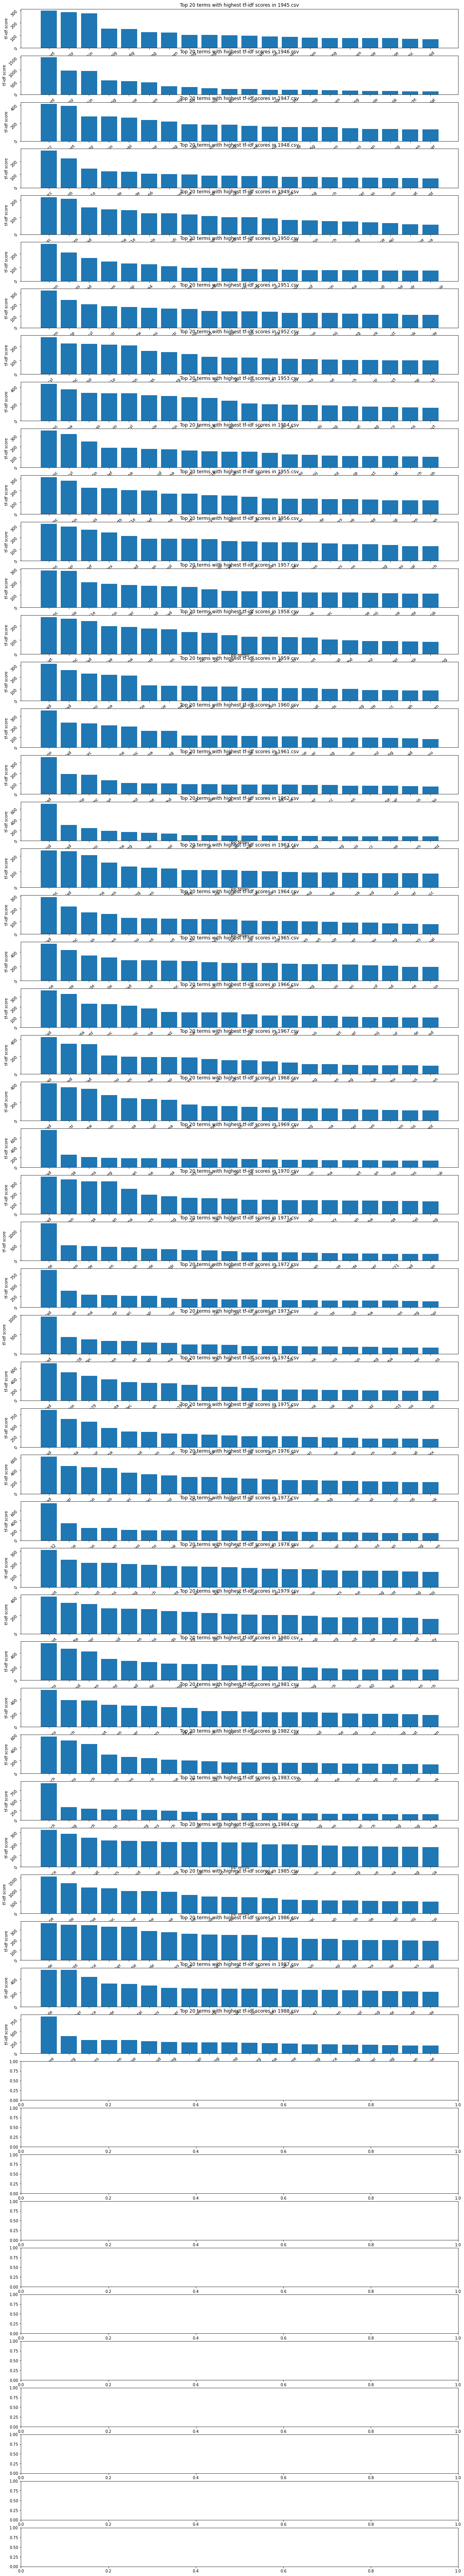

In [9]:
# Instigate n subplots, based on number of documents
fig, axs = plt.subplots(number_of_docs,1, figsize = [20,120], sharey=False)

# Set number of n top terms
n = 20

# construct a list of output file paths using the previous list of text files the relative path for tf_idf_output
output_filenames = [str(txt_file).replace(".txt", ".csv") for txt_file in files_clean]

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

    # output to a csv using the enumerated value for the filename
    one_doc_as_df.to_csv(outdir + '/' + output_filenames[counter])
    
    top_terms = one_doc_as_df[:n]
    ax = axs[counter]
    ax.bar(top_terms['term'], top_terms['score'])
    ax.set_xlabel('Top terms')
    ax.tick_params(labelrotation=45)
    ax.set_ylabel('tf-idf score')
    ax.set_title('Top ' + str(n) + ' terms with highest tf-idf scores in ' + str(output_filenames[counter]))
#plt.savefig('/Users/huijn001/Desktop/No_selected_data1.png', dpi=300)

plt.show()

### Cosine Similarity

In [10]:
vectorizer2 = CountVectorizer()
count_matrix = vectorizer2.fit_transform(all_docs)
cosine_sim = cosine_similarity(count_matrix)
print(cosine_sim)

[[1.         0.87968639 0.79910685 ... 0.53413207 0.5387934  0.53786007]
 [0.87968639 1.         0.85881113 ... 0.54765864 0.56045011 0.55737763]
 [0.79910685 0.85881113 1.         ... 0.68038262 0.69128771 0.68267397]
 ...
 [0.53413207 0.54765864 0.68038262 ... 1.         0.94635249 0.94980144]
 [0.5387934  0.56045011 0.69128771 ... 0.94635249 1.         0.96578403]
 [0.53786007 0.55737763 0.68267397 ... 0.94980144 0.96578403 1.        ]]


Turn cosine_sim into pandas dataframe to visualize in heatmap. Name columns and index after correct year

In [11]:
df_all_docs = pd.DataFrame(cosine_sim, columns=['1970', '1980', '1990', '2010'])
df_all_docs.index = df_all_docs.index

ValueError: Shape of passed values is (55, 55), indices imply (55, 4)

In [ ]:
print(df_all_docs.head())

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_all_docs.corr(), square=True, cmap='RdYlGn', ax=ax)
plt.title('Heatmap of Cosine Similarity scores')
plt.show()